In [ ]:
%cd drive/MyDrive/thesis
%ls

/content/drive/MyDrive/thesis
cc.zh.300.bin  cmn-yue-wuu-wen-parallel-simplified.csv  sgns.merge.char


In [ ]:
from difflib import ndiff
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from statistics import stdev, mean, median
import seaborn as sns

In [ ]:
a = "这个苹果很酸"
b = "搿只苹果老酸个"

In [ ]:
for d in ndiff(b, a):
  print(d[0], d[2])

- 搿
- 只
+ 这
+ 个
  苹
  果
- 老
+ 很
  酸
- 个


In [ ]:
from numpy import delete
# the class to caculate the edit distance, takes two strings as arguments
# return edit distances, edit detailed (deletion, addition and substitution and remain)
# and edit details for the strings (what strings got deleted, added or substituded )

class edit_distance():
  def __init__(self, str1, str2):
    self.each_edit_details = [(s[0], s[2]) for s in ndiff(str1, str2)]

  def get_distance(self):
    edit = {"+":0, "-":0}
    distance = 0
    for edit_code, *_ in self.each_edit_details:
        if edit_code == " ": # same character, so no edits
            distance += max(edit["+"], edit["-"])
            edit["+"] = 0
            edit["-"] = 0
        else: 
            edit[edit_code] += 1
    distance += max(edit["+"], edit["-"])
    return distance  
  
  def get_each_edit(self):
    edits = self.each_edit_details
    subs, delete, add, noedit = [],[],[],[]
    i = 0
    while i < len(edits):
      current = edits[i]
      #print("current:", i, current)
      if current[0] == "-":
        minus, plus = [], []
        if i == len(edits)-1:
          i += 1
        j = i
        while j < len(edits)-1:
          j += 1
          next = edits[j]
          if next[0] == " ":
            i = j
            break
          else:
            if next[0] == "+":
              plus.append(next)
              i = j + 1
            if len(plus)==0 and next[0] == "-":
              minus.append(next)
              i = j + 1
            if len(plus)!=0 and next[0] == "-":
              i = j
              break
        if len(plus)==0:  # no + before " " or - is the last one
          delete.append(current[1])
          for m in minus:
            delete.append(m[1])
        else:
          minus_str = current[1] + "".join([m[1] for m in minus])
          plus_str  = "".join([p[1] for p in plus])
          subs.append((minus_str, plus_str))
          
      elif current[0] == "+":
        minus, plus = [], []
        if i == len(edits)-1:
          i += 1
        j = i
        while j < len(edits)-1:
          j += 1
          next = edits[j]
          if next[0] == " ":
            i = j
            break
          else:
            if next[0] == "-":
              i = j + 1
              minus.append(next)
            if len(minus)==0 and next[0] == "+":
              plus.append(next)
              i = j + 1
            if len(minus)!=0 and next[0] == "+":
              i = j
              break
          #i = j+1
        if len(minus)==0:  # no - before " " or + is the last one
          add.append(current[1])
          for p in plus:
            add.append(p[1])
        else:
          minus_str = "".join([m[1] for m in minus])
          plus_str  = current[1] + "".join([p[1] for p in plus])
          subs.append((minus_str, plus_str))

      else:
        noedit.append(current[1])
        i += 1

    return {"deletion":delete, "addition": add, "substitution":subs, "noedit":noedit}


In [ ]:
edit = edit_distance(a, b)
edit.get_distance(), edit.each_edit_details

(4,
 [('-', '这'),
  ('-', '个'),
  ('+', '搿'),
  ('+', '只'),
  (' ', '苹'),
  (' ', '果'),
  ('-', '很'),
  ('+', '老'),
  (' ', '酸'),
  ('+', '个')])

In [ ]:
edit.get_each_edit()

{'deletion': [],
 'addition': ['个'],
 'substitution': [('这个', '搿只'), ('很', '老')],
 'noedit': ['苹', '果', '酸']}

#### Get all the data and start analysis

In [ ]:
data_all = pd.read_csv("cmn-yue-wuu-wen-parallel-simplified.csv", encoding="utf-8")
cmn = data_all["cmn_sentence"]
wuu = data_all["wuu_sentence"]
yue = data_all["yue_sentence"]
wen = data_all["wen_sentence"]
wen[0]

'卬你试试眙！'

In [ ]:
### punctuations are removed
def get_all_distances(lang1, lang2):
  sentence_edits = {}
  punc = ["。", "，", "！", "？", "'", "\"", ",", ".", "、", "?", "「", "」"]
  num = "0123456789"
  for i in range(len(lang1)):
    #print(i, lang1[i], lang2[i])
    str1 = "".join([t for t in lang1[i] if t not in punc and t not in num])
    str2 = "".join([t for t in lang2[i] if t not in punc and t not in num])
    edit = edit_distance(str1, str2)
    sentence_edits[i] = {"sent1":str1, "sent2":str2, "distance":edit.get_distance(), "each_edit":edit.get_each_edit(), "edit_details":edit.each_edit_details}
  return sentence_edits

In [ ]:
###get sum, largest and average of the edit distance of two languages
def distance_analytical(sentence_edits):
  sum, average, largest = 0, 0, 0
  largest_sents = 0
  all_del, all_add = [], []
  all_subs, all_same = [], []
  for i, edit in enumerate(sentence_edits):
    distance = sentence_edits[i]["distance"]
    each_edit = sentence_edits[i]["each_edit"]
    edit_details = sentence_edits[i]["edit_details"]

    sum += distance
    if distance > largest:
      largest = distance
      largest_sents = (sentence_edits[i]["sent1"], sentence_edits[i]["sent2"])
    
    deletion = each_edit["deletion"]
    add      = each_edit["addition"]
    subs     = each_edit["substitution"]
    same     = each_edit["noedit"]
    all_del += deletion
    all_add += add
    all_subs += subs
    all_same += same

  average = sum / len(sentence_edits)
  edit_details = {"all_del":all_del, "all_add":all_add,"all_subs":all_subs, "all_noEdits":all_same}
  return {"distance_sum":sum, "distance_largest":(largest, largest_sents), "distance_average":average, "each_edit_details": edit_details}

##### Mandarin and Shanghainese

In [ ]:
cmn_wuu = get_all_distances(cmn, wuu)
cmn_wuu[3]

{'sent1': '这个苹果很酸',
 'sent2': '搿只苹果老酸个',
 'distance': 4,
 'each_edit': {'deletion': [],
  'addition': ['个'],
  'substitution': [('这个', '搿只'), ('很', '老')],
  'noedit': ['苹', '果', '酸']},
 'edit_details': [('-', '这'),
  ('-', '个'),
  ('+', '搿'),
  ('+', '只'),
  (' ', '苹'),
  (' ', '果'),
  ('-', '很'),
  ('+', '老'),
  (' ', '酸'),
  ('+', '个')]}

In [ ]:
cmn_wuu_distance = distance_analytical(cmn_wuu)
sum = cmn_wuu_distance["distance_sum"]
largest = cmn_wuu_distance["distance_largest"]
average = cmn_wuu_distance["distance_average"]
edit_details = cmn_wuu_distance["each_edit_details"]
sum, largest, average

(803,
 (29, ('亲爱的 上床吧 不 还不行我在Tatoeba上还必须翻译一些句子', '老公上床啦勿来自啊我还要拉垃 Tatoeba 浪翻翻几句句子哦')),
 5.735714285714286)

In [ ]:
edit_details.keys()
#edit_details["all_del"], edit_details["all_add"], edit_details["all_noEdits"]
edit_details["all_subs"], 

([('我们', '阿拉'),
  ('那又怎样', '哏末哪能呢'),
  ('不', '侬勿'),
  ('说废话', '瞎讲'),
  ('这个', '搿只'),
  ('很', '老'),
  ('别', '勿要'),
  ('了', '记脱'),
  ('天六时', '朝点钟'),
  ('接', '寻'),
  ('他', '伊'),
  ('什么时候', '啥辰光'),
  ('你', '侬'),
  ('不', '勿'),
  ('你', '脱侬'),
  ('把这块', '拿搿只'),
  ('表', '錶'),
  ('给你', '拨侬'),
  ('这些', '搿眼是啥人个'),
  ('这', '搿'),
  ('不', '勿'),
  ('什么时候都', '啥个辰光侪'),
  ('的', '个'),
  ('都在', '侪垃海'),
  ('你', '侬'),
  ('参加的', '呒没多少'),
  ('并不多', '垃海'),
  ('我们的', '阿拉个'),
  ('那个', '诶额'),
  ('的', '个'),
  ('这些', '搿眼'),
  ('都', '侪'),
  ('相', '传统'),
  ('的', '个'),
  ('她', '伊'),
  ('什么都', '啥侪'),
  ('间一间地', '家家'),
  ('了', '起'),
  ('她', '伊'),
  ('天为什么不', '日啥个道理勿'),
  ('他的', '伊个'),
  ('了一', '脱'),
  ('子就什么也', '凳别样物事侪呒'),
  ('才知道', '侪晓得'),
  ('她', '伊'),
  ('你什么时候', '侬啥个辰光'),
  ('你', '侬'),
  ('得', '勿懂'),
  ('这台', '搿部照'),
  ('吗', '伐'),
  ('叫你怎么', '跟侬讲个搿能'),
  ('她很', '伊老欢'),
  ('欢在', '垃'),
  ('上', '浪向'),
  ('那', '哀'),
  ('的', '个'),
  ('位处', '拉垃'),
  ('狭窄', '邪气笑个'),
  ('的', '个'),
  ('正在不断地遭', '勿停个'),
  ('的', '个'),
  ('在二',

##### Mandarin and Cantonese

In [ ]:
cmn_yue = get_all_distances(cmn, yue)
cmn_yue_distance = distance_analytical(cmn_yue)
sum = cmn_yue_distance["distance_sum"]
largest = cmn_yue_distance["distance_largest"]
average = cmn_yue_distance["distance_average"]
edit_details = cmn_yue_distance["each_edit_details"]
sum, largest, average

(1011,
 (28, ('亲爱的 上床吧 不 还不行我在Tatoeba上还必须翻译一些句子', '老公上床啦未得住呀我要喺 Tatoeba 翻译多幾句句子先呀')),
 7.2214285714285715)

In [ ]:
edit_details["all_subs"]

[('们', '哋'),
 ('试看', '吓吖'),
 ('那又怎样', '嗯咁呢'),
 ('不要说废话', '唔好喺度乱噏廿四'),
 ('这个', '呢粒'),
 ('很', '好'),
 ('别忘了明天', '唔好唔记得听日'),
 ('时来接', '点嚟搵'),
 ('相信他是个', '谂佢係'),
 ('什么', '幾'),
 ('发', '發'),
 ('不', '都唔'),
 ('打算把这块手表', '谂住'),
 ('给', '呢隻錶俾'),
 ('这些', '啲'),
 ('是谁的', '边个㗎'),
 ('这', '呢'),
 ('不是什么', '唔係幾'),
 ('适', '啱'),
 ('的', '㗎'),
 ('天', '日'),
 ('在', '喺度'),
 ('参加的', '唔係好多'),
 ('并不多', '有嚟'),
 ('们的', '哋嘅'),
 ('是那', '係'),
 ('是', '係'),
 ('的', '嘅'),
 ('汤姆回', '阿 Tom 返咗'),
 ('这些', '呢啲'),
 ('是', '係'),
 ('相', '噉'),
 ('下来的', '落嚟嘅'),
 ('她穿什么', '佢着咩'),
 ('好看', '咁靓'),
 ('房子', '啲屋'),
 ('地', '噉'),
 ('了', '咗'),
 ('她昨天为什么不来', '佢寻日做咩唔嚟嘅'),
 ('他的', '佢间'),
 ('了一', '咗'),
 ('桌子', '枱'),
 ('什么也没有了', '咩都无喇'),
 ('了', '咗'),
 ('天', '日'),
 ('才', '先'),
 ('她', '佢'),
 ('什么', '幾'),
 ('候回来', '返嚟呀'),
 ('懂得', '识唔识'),
 ('这台', '呢部'),
 ('吗', '呀'),
 ('怎么', '点'),
 ('怎么', '点'),
 ('她很喜欢在', '佢好锺意喺'),
 ('上看', '度睇'),
 ('那', '嗰'),
 ('是', '係'),
 ('的', '嘅'),
 ('位处', '喺'),
 ('的', '嘅'),
 ('正在', '而家'),
 ('地遭受', '咁俾'),
 ('坏', '壞紧'),
 ('在', '喺'),
 (

##### Shanghainese and Cantonese

In [ ]:
wuu_yue = get_all_distances(wuu, yue)
wuu_yue_distance = distance_analytical(wuu_yue)
sum = wuu_yue_distance["distance_sum"]
largest = wuu_yue_distance["distance_largest"]
average = wuu_yue_distance["distance_average"]
edit_details = wuu_yue_distance["each_edit_details"]
sum, largest, average

(1123,
 (29, ('屋里向乱七八糟也呒没问题个但龌龊个闲话我是勿能够接受个', '啲屋狗窦咁乱我都顶得顺但係污糟嘅话我就接受唔到')),
 8.021428571428572)

##### Mandarin and Wenzhounese, to be continued...

In [ ]:
cmn_wen = get_all_distances(cmn, wen)
cmn_wen_distance = distance_analytical(cmn_wen)
sum = cmn_wen_distance["distance_sum"]
largest = cmn_wen_distance["distance_largest"]
average = cmn_wen_distance["distance_average"]
edit_details = cmn_wen_distance["each_edit_details"]
sum, largest, average

(804,
 (19, ('亲爱的 上床吧 不 还不行我在Tatoeba上还必须翻译一些句子', '亲爱得走床里呐未还未呐我缩Tatoeba上还有厘句子着翻译')),
 5.742857142857143)

The substitutions that are extracted do show some good alignments of the two languages

In [ ]:
edit_details["all_subs"]

[('我们', '卬你'),
 ('看', '眙'),
 ('又怎样', '就訾那能爻'),
 ('不要说', '覅讲'),
 ('这', '居'),
 ('别忘了', '覅悗记爻'),
 ('天', '朝'),
 ('时', '点钟走'),
 ('他', '渠'),
 ('什么时候出发', '若能届走'),
 ('不会忘', '覅悗'),
 ('把这块', '逮居个'),
 ('给', '匄'),
 ('这些', '居厘'),
 ('谁的', '何乜人个'),
 ('这', '居'),
 ('则不', '定否'),
 ('什么时候都适', '若能届沃可以'),
 ('的', '个'),
 ('天都在', '日沃是得'),
 ('的', '个'),
 ('不', '否'),
 ('们', '厘'),
 ('那', '许'),
 ('的', '个'),
 ('回', '走'),
 ('了', '转哦罢'),
 ('这些古', '居厘'),
 ('都', '沃'),
 ('来的', '个'),
 ('她穿什么都', '渠著何乜沃'),
 ('看', '眙'),
 ('房子', '屋宕'),
 ('地着了火', '能烧起'),
 ('她', '渠'),
 ('天为什么不', '夜妆嚷冇走'),
 ('他的房', '渠个'),
 ('了', '爻'),
 ('什么也没有了', '何乜沃冇'),
 ('了', '去'),
 ('天', '日'),
 ('才知道', '新晓得'),
 ('她失踪了', '渠走狃宕罢'),
 ('什么时候回', '若能届走'),
 ('懂', '晓'),
 ('这', '居'),
 ('吗', '啊伐'),
 ('怎么', '訾那'),
 ('怎么', '訾那'),
 ('她', '渠'),
 ('在', '缩'),
 ('看', '眙'),
 ('那', '许'),
 ('的', '个'),
 ('处', '于'),
 ('附近', '边埏'),
 ('窄', '个'),
 ('的', '个'),
 ('在', '是搭'),
 ('断地', '停能'),
 ('在', '是'),
 ('该', '居'),
 ('从', '缩'),
 ('自', '你'),
 ('的情绪', '个脾气'),
 ('房子', '屋宕'),
 ('没', '冇'),

#### Sample 1000 times for an average sent edit distance distribution between each language pair

In [ ]:
lang_pair=[]
for i in range(len(cmn)):
  lang_pair.append((cmn[i], wen[i]))
lang_pair

[('我们试试看！', '卬你试试眙！'),
 ('那又怎样?', '那就訾那能爻？'),
 ('不要说废话！', '覅讲废话！'),
 ('这个苹果很酸。', '居个苹果酸显酸。'),
 ('别忘了明天六时来接我。', '覅悗记爻明朝六点钟走来接我。'),
 ('我相信他是个聪明人。', '我相信渠是个聪明人。'),
 ('什么时候出发最方便你？', '若能届走最方便啊你？'),
 ('我永远不会忘记你。', '我永远覅悗记你。'),
 ('我打算把这块手表送给你。', '我打算逮居个手表送匄你。'),
 ('这些书是谁的？', '居厘书是何乜人个？'),
 ('这条规则不是什么时候都适用的。', '居条规定否是若能届沃可以用个。'),
 ('天气每天都在变。', '天气每日沃是得变。'),
 ('你应该先和你的父母谈谈。', '你应该伉你爸妈谈一谈先。'),
 ('参加的人并不多。', '参加个人并否多。'),
 ('我们的结论就是，那个传言是真的。', '我厘的结论就是，许个传言是真个.'),
 ('汤姆回乡下了。', '汤姆走乡下转哦罢。'),
 ('这些古老习俗都是一代一代相传下来的。', '居厘老个习俗沃是一代一代传下个。'),
 ('她穿什么都好看。', '渠著何乜沃好眙。'),
 ('房子一间一间地着了火。', '屋宕一间一间能烧起。'),
 ('她昨天为什么不来？', '渠昨夜妆嚷冇走来？'),
 ('他的房间除了一张桌子，就什么也没有了。', '渠个间里除爻一张桌，就何乜沃冇。'),
 ('过了三天我才知道原来她失踪了。', '过去三日我新晓得原来渠走狃宕罢。'),
 ('你什么时候回来？', '你若能届走来？'),
 ('你懂得用这台相机吗？', '你晓得用居台相机啊伐?'),
 ('我叫你怎么做，你就怎么做。', '我叫你訾那做，你就訾那做。'),
 ('她很喜欢在电视上看网球比赛。', '渠很喜欢缩电视上眙网球比赛。'),
 ('那幅画是印象派的大师级作品。', '许幅画是印象派个大师级作品。'),
 ('位处赤道附近一个狭窄区域的热带雨林，正在不断地遭受人类的破坏，预计在二零零零年之前，该区域将会有五分之四的热带雨林从地球上消失。',
  '位于赤道边埏一个狭个区域个热带雨林，正是搭不停能遭受人类的破坏，预计是二零零零年之前，居区域会有五

In [ ]:
def get_distribution(lang1, lang2, sample_n=1050):
  lang_pair = []
  for i in range(len(lang1)):
    lang_pair.append((lang1[i], lang2[i]))
  
  all_avgED = []
  for i in range(sample_n):
    tmp_lang_pair = random.choices(lang_pair, k=len(lang_pair))
    distances = get_all_distances(tmp_lang_pair[0], tmp_lang_pair[1])
    avgED = distance_analytical(distances)["distance_average"]
    #if avgED < 40:
      #print(tmp_lang_pair)
    all_avgED.append(avgED)
  return sorted(all_avgED)

In [ ]:
def plot(df, color=None, annotate_mean=True):
  # Calculating mean and standard deviation
  m, sd = 0, 0 
  ax = sns.kdeplot()
  for name in df.columns:
    md = median(df[name])
    mn = mean(df[name])
    sd = stdev(df[name])
    print("Language pair:", name[:3]+",", name[4:8])
    print("mean: ", mn, ";", "median: ", md, "standard derivation: ", sd)
    print("2u: ", md-2*sd, "-", md+2*sd)
    #ax = sns.histplot(df, stat="probability", kde=True, color=color) 
    if annotate_mean:
      ax.axvline(x=md, color="pink")
      ax.annotate(s="median: "+str(md)[:4], xy=(md+0.05,0.1))
    ax = sns.kdeplot(data=df, color=color, common_norm=True) #bw_adjust=.5) 
    ax.plot()

In [ ]:
# remove the lowest and highest 25 samples
sample_cwe = get_distribution(cmn, wen)[25:-25]
sample_cwu = get_distribution(cmn, wuu)[25:-25]
sample_cy = get_distribution(cmn, yue)[25:-25]
sample_ww = get_distribution(wuu, wen)[25:-25]
sample_wuy = get_distribution(wuu, yue)[25:-25]
sample_wey = get_distribution(wen, yue)[25:-25]
print(sample_cwe), print(len(sample_cwe))

[5.5, 5.5, 5.5, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.0, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 6.5, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.0, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 7.5, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.0, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 8.5, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.0, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5, 9.5,

(None, None)

In [ ]:
stack = np.stack((np.array(sample_cwe),np.array(sample_cwu), np.array(sample_cy)), axis=1)
all_cmn_df = pd.DataFrame(stack, columns=["cmn_wen", "cmn_wuu", "cmn_yue"])
all_cmn_df

,cmn_wen,cmn_wuu,cmn_yue
0,5.5,6.0,5.5
1,5.5,6.0,5.5
2,5.5,6.0,5.5
3,6.0,6.0,5.5
4,6.0,6.0,5.5
...,...,...,...
995,30.0,31.0,30.5
996,30.0,31.0,30.5
997,30.5,31.0,31.0
998,30.5,31.0,31.0


Almost overlapping ditributions, cmn and yue has the highest sd and relatively high mean and median, suggests they are most distinct (and cmn and wen has the least edit distance)?

Language pair: cmn, wen
mean:  13.079 ; median:  12.5 standard derivation:  4.532416772738557
2u:  3.4351664545228857 - 21.564833545477114
Language pair: cmn, wuu
mean:  13.224 ; median:  12.0 standard derivation:  4.639919487755456
2u:  2.7201610244890873 - 21.279838975510913
Language pair: cmn, yue
mean:  12.9995 ; median:  12.0 standard derivation:  4.787605969680558
2u:  2.4247880606388836 - 21.575211939361118


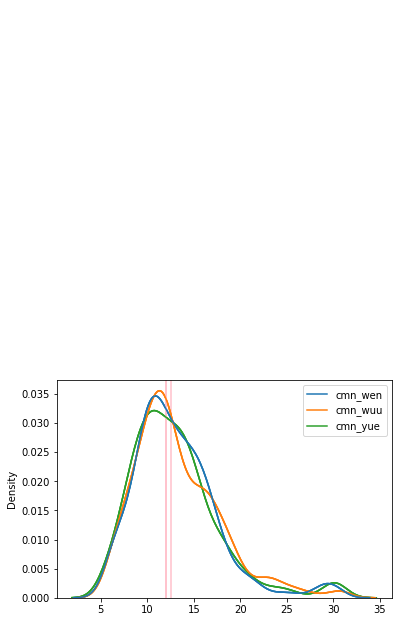

In [ ]:
plot(all_cmn_df)

wuu and yue has the largest mean and median pair and the largest sd, while wen and yue has them in smallest values.
Larger mean and median indicates bigger difference on average, and larger sd suggests the spread of values around the mean or median is more frequent. So wen and yue has the least edit distance?

Language pair: wuu, wen
mean:  13.4285 ; median:  12.5 standard derivation:  4.780113726391584
2u:  2.9397725472168315 - 22.060227452783167
Language pair: wuu, yue
mean:  13.4 ; median:  13.0 standard derivation:  4.940081416778918
2u:  3.1198371664421636 - 22.880162833557836
Language pair: wen, yue
mean:  12.5775 ; median:  12.0 standard derivation:  4.210875826384011
2u:  3.5782483472319786 - 20.421751652768023


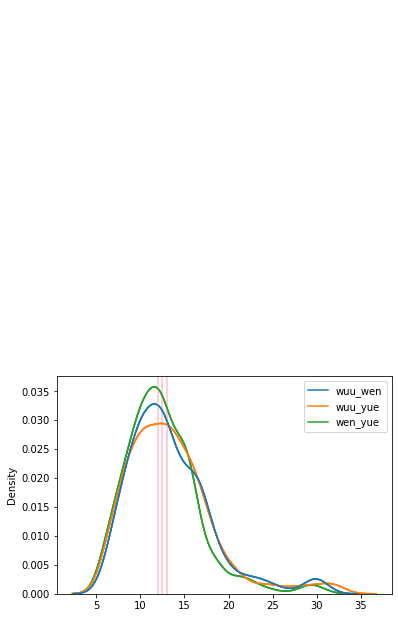

In [ ]:
stack = np.stack((np.array(sample_ww),np.array(sample_wuy), np.array(sample_wey)), axis=1)
all_cmn_df = pd.DataFrame(stack, columns=["wuu_wen", "wuu_yue", "wen_yue"])
plot(all_cmn_df)